      CLUSTERING SANDBOX – PENGUIN DATA (UNSUP)
Feature set            : bill_2d
Use scaling            : False
K (clusters)           : 3
Init method            : k-means++
Random state           : 0
Reveal species at end? : True

Scaling OFF: using original units (mm / g).

=== UNSUPERVISED CLUSTERING RESULTS (NO SPECIES USED) ===
Results for K = 3:
  SSE (inertia)    : 2265.07
  Silhouette score : 0.484



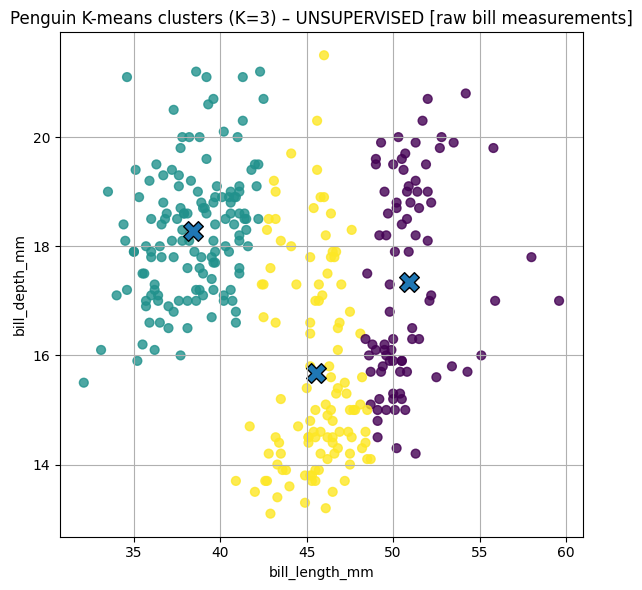

Running elbow and silhouette experiment...


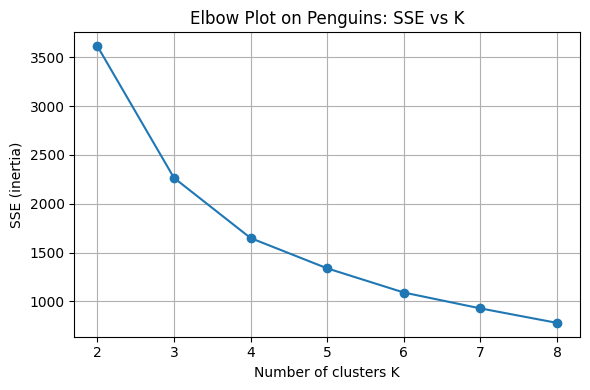

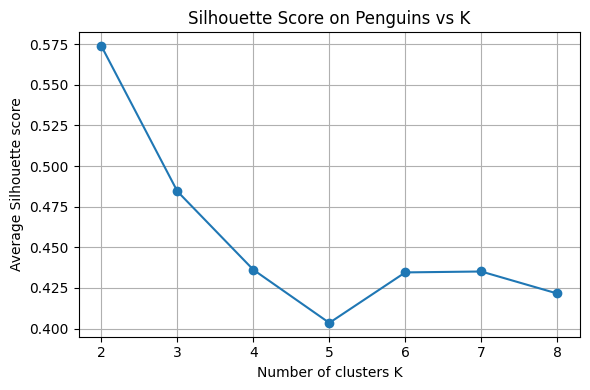


   NOW REVEALING TRUE SPECIES (FOR COMPARISON)
Reminder: K-means did NOT use these labels.
We only compare discovered clusters to species.



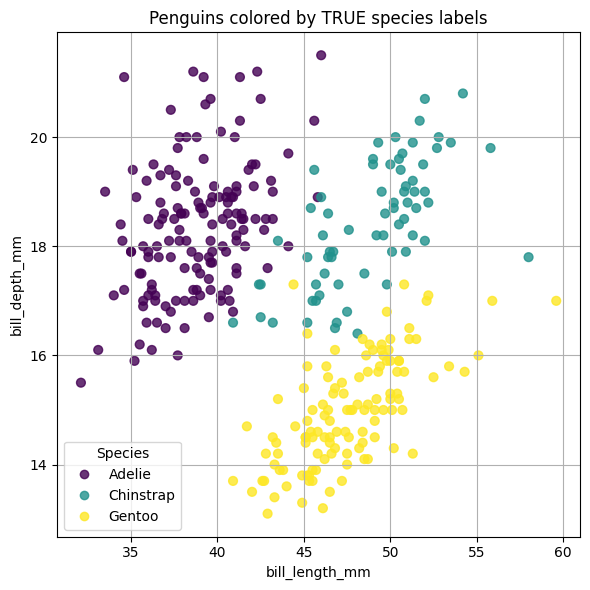


Done. Adjust settings in the STUDENT CONFIGURATION SECTION
and re-run to explore new experiments.


In [1]:
"""
Penguin Clustering Sandbox (K-means, Unsupervised First)
========================================================

- Uses Palmer Penguins dataset.
- K-means is trained *without* species labels (unsupervised).
- Species are revealed only at the end (optional) for comparison.

To run experiments:
1. Change values in the STUDENT CONFIGURATION SECTION.
2. Run the whole script.
3. Inspect the console output and plots.
"""

# ============================================================
# ====================== IMPORTS =============================
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# ============================================================
# =============== STUDENT CONFIGURATION SECTION ===============
# ===============        *** EDIT ME ***        ===============
# ============================================================

# Choose the feature set:
#   "bill_2d"  -> uses (bill_length_mm, bill_depth_mm)
#   "body_4d"  -> uses (bill_length_mm, bill_depth_mm,
#                       flipper_length_mm, body_mass_g)
FEATURE_SET = "bill_2d"

# Scale features before clustering?
#   True  -> standardize to mean 0, std 1   (recommended)
#   False -> use raw units (mm, g)
# USE_SCALING = True
USE_SCALING = False # Experiment 1: Turn scaling off

# Number of clusters K for K-means
N_CLUSTERS = 3

# Initialization method for K-means:
#   "k-means++" (recommended) or "random"
INIT_METHOD = "k-means++"

# Random seed for reproducibility (try 0, 1, 2, 42, ...)
RANDOM_STATE = 0

# Reveal TRUE species labels at the end?
# Only works when FEATURE_SET == "bill_2d".
REVEAL_SPECIES = True

# Range of K values to test in elbow + silhouette plots
K_RANGE = range(2, 9)

# ============================================================
# ============ END OF STUDENT CONFIGURATION SECTION ===========
# ============================================================


# ============================================================
# ================ DATA LOADING / SELECTION ==================
# ============================================================

def load_penguin_features(feature_set="bill_2d"):
    """
    Load the Palmer Penguins dataset and select a feature subset.

    Parameters
    ----------
    feature_set : str
        "bill_2d" -> use bill length & bill depth (2D)
        "body_4d" -> use bill length, bill depth, flipper length, body mass

    Returns
    -------
    X : np.ndarray
        Selected feature matrix with no missing values.
    y_true : np.ndarray
        Integer-encoded species labels (0, 1, 2). Not used in clustering.
    feature_names : list of str
        Names of the selected features.
    species_names : list of str
        Human-readable species names, for legends.
    """
    penguins = sns.load_dataset("penguins")
    penguins = penguins.dropna()  # drop rows with missing values

    # Encode species as integers
    species_names = sorted(penguins["species"].unique())
    species_to_int = {name: i for i, name in enumerate(species_names)}
    y_true = penguins["species"].map(species_to_int).values

    if feature_set == "bill_2d":
        feature_cols = ["bill_length_mm", "bill_depth_mm"]
    elif feature_set == "body_4d":
        feature_cols = [
            "bill_length_mm",
            "bill_depth_mm",
            "flipper_length_mm",
            "body_mass_g",
        ]
    else:
        raise ValueError("FEATURE_SET must be 'bill_2d' or 'body_4d'.")

    X = penguins[feature_cols].values
    feature_names = feature_cols

    return X, y_true, feature_names, species_names


def maybe_scale(X, use_scaling=True):
    """
    Optionally standardize features.

    When use_scaling is True:
        - Each feature is transformed to mean 0, std 1.

    Returns
    -------
    X_scaled : np.ndarray
    scaler   : fitted StandardScaler or None
    """
    if use_scaling:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, scaler
    else:
        return X, None


# ============================================================
# ================== CLUSTERING FUNCTIONS ====================
# ============================================================

def run_kmeans(X, n_clusters=3, init="k-means++", random_state=0):
    """
    Run K-means *without* any labels (fully unsupervised).

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (scaled or unscaled).
    n_clusters : int
        Number of clusters K.
    init : str
        Initialization strategy.
    random_state : int
        Random seed.

    Returns
    -------
    labels : np.ndarray
        Cluster assignment for each point.
    inertia : float
        Sum of squared distances to nearest centroid (SSE).
    sil_score : float or None
        Average silhouette score.
    kmeans : KMeans
        Fitted KMeans object.
    """
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=10,
        random_state=random_state
    )
    labels = kmeans.fit_predict(X)
    inertia = kmeans.inertia_

    sil_score = None
    if n_clusters > 1 and len(np.unique(labels)) > 1:
        sil_score = silhouette_score(X, labels)

    return labels, inertia, sil_score, kmeans


# ============================================================
# ====================== PLOTTING ============================
# ============================================================

def plot_clusters_2d(X_2d, labels, kmeans, feature_names, title):
    """
    Scatter plot of 2D clustered data with centroids.
    """
    plt.figure(figsize=(6, 6))

    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=40, alpha=0.8)

    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="X",
        s=200,
        edgecolor="black"
    )

    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_true_species_2d(X_2d, y_true, feature_names, species_names):
    """
    Scatter plot colored by TRUE species labels.
    """
    plt.figure(figsize=(6, 6))

    scatter = plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=y_true,
        s=40,
        alpha=0.8
    )

    handles, _ = scatter.legend_elements()
    plt.legend(handles, species_names, title="Species")

    plt.title("Penguins colored by TRUE species labels")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def elbow_and_silhouette_experiment(X, k_range):
    """
    Plot SSE (elbow) and Silhouette scores across k_range.
    """
    inertias = []
    silhouettes = []

    for k in k_range:
        labels, inertia, sil_score, _ = run_kmeans(
            X,
            n_clusters=k,
            init="k-means++",
            random_state=RANDOM_STATE
        )
        inertias.append(inertia)
        silhouettes.append(sil_score)

    # Elbow (SSE) plot
    plt.figure(figsize=(6, 4))
    plt.plot(list(k_range), inertias, marker="o")
    plt.title("Elbow Plot on Penguins: SSE vs K")
    plt.xlabel("Number of clusters K")
    plt.ylabel("SSE (inertia)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Silhouette plot
    plt.figure(figsize=(6, 4))
    plt.plot(list(k_range), silhouettes, marker="o")
    plt.title("Silhouette Score on Penguins vs K")
    plt.xlabel("Number of clusters K")
    plt.ylabel("Average Silhouette score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ============================================================
# ======================== MAIN ==============================
# ============================================================

def main():
    """
    Full sandbox run:
      1. Loads data and applies selected features.
      2. Applies scaling (optional).
      3. Runs unsupervised K-means with chosen settings.
      4. Shows cluster scatterplot (2D only).
      5. Shows elbow + silhouette curves across K_RANGE.
      6. Optionally reveals TRUE species plot at the end.
    """
    print("===================================================")
    print("      CLUSTERING SANDBOX – PENGUIN DATA (UNSUP)")
    print("===================================================")
    print(f"Feature set            : {FEATURE_SET}")
    print(f"Use scaling            : {USE_SCALING}")
    print(f"K (clusters)           : {N_CLUSTERS}")
    print(f"Init method            : {INIT_METHOD}")
    print(f"Random state           : {RANDOM_STATE}")
    print(f"Reveal species at end? : {REVEAL_SPECIES}")
    print("===================================================\n")

    # 1) Load data
    X_raw, y_true, feature_names, species_names = load_penguin_features(FEATURE_SET)

    # 2) Optional scaling
    X, scaler = maybe_scale(X_raw, use_scaling=USE_SCALING)
    if USE_SCALING:
        print("Scaling ON: features standardized (mean 0, std 1).")
    else:
        print("Scaling OFF: using original units (mm / g).")
    print()

    # 3) Run unsupervised K-means
    labels, inertia, sil_score, kmeans = run_kmeans(
        X,
        n_clusters=N_CLUSTERS,
        init=INIT_METHOD,
        random_state=RANDOM_STATE
    )

    print("=== UNSUPERVISED CLUSTERING RESULTS (NO SPECIES USED) ===")
    print(f"Results for K = {N_CLUSTERS}:")
    print(f"  SSE (inertia)    : {inertia:.2f}")
    if sil_score is not None:
        print(f"  Silhouette score : {sil_score:.3f}")
    else:
        print("  Silhouette score : not defined (check K and labels).")
    print()

    # 4) 2D cluster plot (only for bill_2d)
    if FEATURE_SET == "bill_2d":
        title = f"Penguin K-means clusters (K={N_CLUSTERS}) – UNSUPERVISED"
        if USE_SCALING:
            title += " [scaled bill features]"
        else:
            title += " [raw bill measurements]"
        plot_clusters_2d(X, labels, kmeans, feature_names, title)
    else:
        print("FEATURE_SET is 'body_4d': skipping 2D cluster plot.\n")

    # 5) Elbow + silhouette curves for K_RANGE
    print("Running elbow and silhouette experiment...")
    elbow_and_silhouette_experiment(X, K_RANGE)

    # 6) Optional species reveal
    if REVEAL_SPECIES and FEATURE_SET == "bill_2d":
        print("\n===============================================")
        print("   NOW REVEALING TRUE SPECIES (FOR COMPARISON)")
        print("===============================================")
        print("Reminder: K-means did NOT use these labels.")
        print("We only compare discovered clusters to species.\n")
        plot_true_species_2d(X, y_true, feature_names, species_names)
    elif REVEAL_SPECIES and FEATURE_SET != "bill_2d":
        print("\nSpecies comparison only implemented for 'bill_2d'.")
        print("Set FEATURE_SET = 'bill_2d' to see species plot.")
    else:
        print("\nSpecies labels are hidden (REVEAL_SPECIES = False).")
        print("This run remains purely unsupervised.")

    print("\nDone. Adjust settings in the STUDENT CONFIGURATION SECTION")
    print("and re-run to explore new experiments.")


if __name__ == "__main__":
    main()

# Interpretation of Configuration Settings

The following explains each configuration value used in the clustering sandbox:

- **Feature set: `bill_2d`**  
  Uses only two measured attributes—bill length and bill depth.  
  This keeps the feature space two-dimensional so cluster patterns can be visualized directly.

- **Use scaling: `True`**  
  Standardizes the features (mean = 0, standard deviation = 1).  
  Scaling prevents larger-range measurements from dominating the distance calculations used by K-means.

- **K (clusters): `3`**  
  Instructs K-means to form exactly three groups.  
  The algorithm does not use species labels; it discovers patterns solely from the numeric features.

- **Init method: `k-means++`**  
  Uses a smart centroid initialization technique that spreads initial centers apart.  
  This typically produces more stable and better-quality clusters than random initialization.

- **Random state: `0`**  
  Sets a fixed random seed so results are repeatable.  
  Changing this value allows students to observe how initialization randomness affects clustering outcomes.

- **Reveal species at end?: `True`**  
  After clustering (unsupervised), the script will display the true species labels for comparison.  
  These labels are used *only* for interpretation and are never given to the algorithm.

# Interpretation of Clustering Output

- **Scaling ON**  
  The features were standardized so each has mean 0 and standard deviation 1.  
  This ensures that bill length and bill depth contribute equally to the distance calculations used by K-means.

---

## Unsupervised Clustering Results (Species Labels Not Used)

### Results for `K = 3`

- **SSE (inertia): 183.13**  
  This represents the total squared distance between each point and the centroid of its assigned cluster.  
  A lower SSE indicates tighter, more compact clusters.  
  SSE decreases as K increases, which is why we later use the elbow plot to determine whether 3 is an appropriate choice.

- **Silhouette score: 0.522**  
  This value measures how well-separated the clusters are.  
  It ranges from **-1 to 1**, where:
  - **> 0.5** indicates clear, well-defined clusters  
  - **0.2–0.5** indicates overlapping or uncertain boundaries  
  - **< 0** indicates misassigned points  

  A score of **0.522** suggests the three clusters are reasonably distinct based on the chosen bill measurements.

# Interpretation of the Unsupervised K-means Cluster Plot (K=3)

This scatterplot shows the result of running **K-means with K=3** on the penguin dataset using only two features:

- `bill_length_mm`
- `bill_depth_mm`

The features have been **scaled** so that both contribute equally to the clustering.

## What the plot shows

- Each point is a penguin, positioned according to its bill measurements.
- The **three colors** represent the cluster assignments created by K-means.
- The **large X markers** represent the computed centroids of each cluster.
- Because this is **unsupervised**, K-means did *not* know the species labels when forming these groups.

## Interpretation of the clusters

- The three clusters form **distinct, roughly elliptical groups** in this feature space.
- One cluster groups penguins with **shorter, deeper bills**.
- Another cluster groups those with **longer, shallower bills**.
- A third cluster represents penguins with **intermediate bill length and depth**.
- The clear separation between colors visually matches the **Silhouette score of ~0.52**, suggesting reasonably well-defined boundaries.

## What this means conceptually

- Even without species information, K-means is able to extract **natural structure** in the measurements.
- These clusters reflect **real, quantifiable differences in morphology**.
- The algorithm is discovering patterns humans might interpret as species differences, size categories, or ecological adaptations—  
  but **we do not confirm that** until we reveal species labels later.

# Interpretation of the Elbow Plot (Penguins Dataset)

This plot shows the **Sum of Squared Errors (SSE)** for different values of **K** in K-means clustering, using the penguin bill measurements.

## What SSE Represents
- SSE measures how tightly points in each cluster are grouped around their centroid.  
- Lower SSE means more compact clusters.  
- SSE always decreases as K increases, which is why we look for a **bend** in the curve rather than the lowest value.

## Reading the Plot
- The curve drops sharply from **K = 2 → K = 3**, indicating a major improvement in cluster compactness.
- After **K = 3**, the reductions become smaller and more gradual:
  - K=4 gives some improvement
  - K=5, K=6, ..., K=8 show diminishing returns

## Identifying the "Elbow"
- The “elbow” is the point where adding more clusters stops giving significant improvement.
- Here, the elbow is around **K = 3**.

## Interpretation
- A value of **K = 3** appears to balance:
  - good cluster compactness  
  - minimum necessary complexity  
- This aligns with the visual cluster separation seen earlier.
- Note: K-means did not use species labels—it only used bill features—but the elbow suggests **three natural groupings** in the data.

# Interpretation of the Silhouette Plot (Penguins Dataset)

This plot shows the **average Silhouette score** for different values of **K** in K-means clustering.

## What the Silhouette Score Represents
The Silhouette score measures how well-separated the clusters are.  
It ranges from **-1 to 1**:

- **> 0.5** → strong, well-separated clusters  
- **0.3–0.5** → moderate separation, some overlap  
- **< 0.3** → weak separation or ambiguous boundaries  
- **< 0** → points assigned to the wrong clusters  

It evaluates both:
- how close each point is to its own cluster  
- how far it is from the nearest other cluster  

## Reading the Plot
- **K = 3 produces the highest score (~0.52)**, indicating the best-defined clustering.
- **K = 2** is reasonably good but worse than K=3.
- For **K ≥ 4**, the score drops noticeably:
  - Clusters become less distinct
  - Boundaries blur
  - Some points are likely assigned to suboptimal clusters

## Interpretation
- The peak at **K = 3** indicates the clearest natural grouping in the data.
- After K=3, adding more clusters **does not create better structure**; it subdivides groups that are already coherent.
- The Silhouette analysis supports the same conclusion as the elbow plot:  
  **K = 3 is the most meaningful choice for this dataset.**

# Interpretation of the TRUE Species Plot (Penguins Dataset)

This scatterplot shows the real biological species for each penguin, using:

- **bill_length_mm** (x-axis)
- **bill_depth_mm** (y-axis)

Each point is colored according to its **true species label**, not predicted clusters.

## What the plot shows

- **Adelie (purple)**  
  Cluster tightly on the left with **shorter** bills and **greater depth**.

- **Chinstrap (teal)**  
  Positioned in the middle–right region with **longer** bills and **moderate depth**.

- **Gentoo (yellow)**  
  Cluster distinctly at the bottom-right with **longer** bills and **shallower depth**.

## Separation of Species

The features create **three naturally distinct biological groups**:

- Adelie are compact and strongly grouped.  
- Gentoo form a wide, separate cluster with shallow bills.  
- Chinstrap sits between the other two in both length and depth.

The separation helps explain why **K = 3** was the best value in:
- The **elbow plot**  
- The **silhouette analysis**  
- The **unsupervised K-means results**

## Why this matters

- K-means discovered three structure-defined groups **without ever seeing these labels**.  
- When we finally reveal species, we see strong alignment:
  - Clustering captured **real morphological differences**.
  - Distinct species structure is visible in the raw measurements.

This confirms that **unsupervised learning can meaningfully recover real-world categories** when those categories reflect natural measurement patterns.

## Experiment 1 — Turn Scaling OFF

**Goal:**  
See how clustering changes when features remain in their original measurement units (millimeters) instead of being standardized.  
This experiment shows how K-means behaves when one feature has a much larger numerical range than the other.

---

### Settings + Interpretation Prompts (Inside One Code Block)

```python
Experiment 1 — Turn Scaling OFF

SETTINGS FOR THIS EXPERIMENT
----------------------------
FEATURE_SET    = "bill_2d"
USE_SCALING    = False      # TURN SCALING OFF
N_CLUSTERS     = 3
INIT_METHOD    = "k-means++"
RANDOM_STATE   = 0
REVEAL_SPECIES = True


INTERPRETATION PROMPTS (WHAT TO LOOK FOR)
-----------------------------------------

Boundary Shape:
Do clusters stretch, skew, or shift when features are no longer standardized?

Feature Dominance:
Does either bill length or bill depth overpower the other because of scale differences?

Silhouette Score:
Does the Silhouette score become higher, lower, or more unstable when scaling is removed?
Why might that happen in this dataset?

Species Alignment:
Does removing scaling improve or degrade the match between clusters and the true species groups?

Takeaway:
What does this experiment reveal about WHY scaling often matters in unsupervised learning,
especially when features use different measurement scales?

STUDENT ANSWER
------------------------------------------
**Scaling** prevents larger-range measurements from dominating the distance calculations used by K-means.

Without Scaling, the experiement degraded. Bill Depth and Bill Length values are of the range 15-25 and 30-60 respectively. This results in significantly higher SEE (inertia) score, meaning the total squared distance between each point and the centroid of its assigned cluster are larger, less compact. A Silhouette score of **0.484** suggests the three clusters are reasonably distinct based on the chosen bill measurements.

Scaling matters in unsupervised learning because it ensures that all measures contribute to the model's analysis and prevents one feature with larger values from dominating the result. 

---

# ✅ **Markdown Cell — Experiment 2**

```markdown
## Experiment 2 — Search for the Best K

**Goal:**  
Use elbow and silhouette metrics to compare different values of K.

---

### Settings + Interpretation Prompts

```python
Experiment 2 — Searching for the Best K

SETTINGS TO TRY
---------------
Run multiple times with:
N_CLUSTERS = 2
N_CLUSTERS = 3
N_CLUSTERS = 4
N_CLUSTERS = 5

CONSTANT SETTINGS
-----------------
FEATURE_SET  = "bill_2d"
USE_SCALING  = True
INIT_METHOD  = "k-means++"
RANDOM_STATE = 0


INTERPRETATION PROMPTS
----------------------

Elbow Point:
Where is the elbow in the SSE curve?

Silhouette Peak:
For which K is the silhouette score highest?

Visual Separation:
Do visual clusters agree with the metric-based choice?

Over/Under-Clustering:
Which K values feel too small or too large?

---

# ✅ **Markdown Cell — Experiment 3**

```markdown
## Experiment 3 — Over-Clustering (Too Many Clusters)

**Goal:**  
See how K-means behaves when K is unreasonably large.

---

### Settings + Interpretation Prompts

```python
Experiment 3 — Over-Clustering

SETTINGS
--------
FEATURE_SET    = "bill_2d"
USE_SCALING    = True
N_CLUSTERS     = 6   # Try 7 or 8 as well
INIT_METHOD    = "k-means++"
RANDOM_STATE   = 0
REVEAL_SPECIES = True


INTERPRETATION PROMPTS
----------------------

Fragmentation:
Do clusters break apart into tiny or meaningless pieces?

Which Species Split:
Which species is split into multiple clusters?

Silhouette Score:
How much lower is the score compared to K=3?

Interpretability:
What does this reveal about the cost of using too many clusters?

---

# ✅ **Markdown Cell — Experiment 4**

```markdown
## Experiment 4 — Under-Clustering (Too Few Clusters)

**Goal:**  
Force K-means to merge distinct structure into too few groups.

---

### Settings + Interpretation Prompts

```python
Experiment 4 — Under-Clustering

SETTINGS
--------
FEATURE_SET    = "bill_2d"
USE_SCALING    = True
N_CLUSTERS     = 2
INIT_METHOD    = "k-means++"
RANDOM_STATE   = 0
REVEAL_SPECIES = True


INTERPRETATION PROMPTS
----------------------

Merged Species:
Which species get merged into a single cluster?

Boundary Cuts:
Does K-means cut through a species instead of grouping it?

Silhouette Score:
Does the score indicate loss of structure?

Minimum Meaningful K:
What does this experiment reveal about the smallest K that preserves real structure?

---

# ✅ **Markdown Cell — Experiment 5**

```markdown
## Experiment 5 — Initialization and Randomness

**Goal:**  
Observe how initialization affects cluster stability.

---

### Settings + Interpretation Prompts

```python
Experiment 5 — Initialization and Randomness

SETTINGS TO TRY
----------------
Option A:
INIT_METHOD  = "k-means++"
RANDOM_STATE = 0, 1, 2

Option B:
INIT_METHOD  = "random"
RANDOM_STATE = 0, 1, 2


INTERPRETATION PROMPTS
----------------------

Stability:
Does k-means++ produce consistent clusters across random seeds?

Variability:
Do results shift more when using random initialization?

Metric Fluctuation:
Do SSE or silhouette scores jump noticeably?

Why It Matters:
Why does initialization matter more on some datasets than others?

---

# ✅ **Markdown Cell — Experiment 6**

```markdown
## Experiment 6 — Add More Features (4D Clustering)

**Goal:**  
See how additional features change the clustering structure.

---

### Settings + Interpretation Prompts

```python
Experiment 6 — Adding More Features (4D)

SETTINGS
--------
FEATURE_SET    = "body_4d"   # 4 features instead of 2
USE_SCALING    = True
N_CLUSTERS     = 3
INIT_METHOD    = "k-means++"
RANDOM_STATE   = 0
REVEAL_SPECIES = False       # Cannot compare species visually in 4D


INTERPRETATION PROMPTS
----------------------

Silhouette Change:
Is the score higher or lower than in 2D?

Added Structure:
Do new features improve natural separation?

Added Noise:
Do extra dimensions reduce clarity?

Dimensionality Insight:
Does this show that “more features” is not always better?

---

# ✅ Big-Picture Questions**

```markdown
# Big-Picture Questions (After All Experiments)

Answer these once you finish all the experiments:

1. Which features seem most responsible for creating the three natural clusters?  
2. When did the elbow point and Silhouette disagree, and how would you justify your chosen K?  
3. How did turning off scaling change cluster shapes or boundaries?  
4. When did adding more features improve cluster quality, and when did it make things worse?  
5. How closely did unsupervised clusters match the true species labels?  
6. What strengths and weaknesses did you observe in K-means for real biological data?  
7. If you had no labels at all, what story would you tell about the clusters in this dataset?  
8. What general guidelines would you give someone choosing K for a brand-new dataset?